## Numpy based MLP

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Layer():
    def __init__(self):
        pass
    
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, x):
        raise NotImplementedError
    
    def update(self, learning_rate):
        raise NotImplementedError

In [4]:
class Activation(Layer):
    def __init__(self, size):
        self.size = size
             
    def update(self, learning_rate):
        pass
    
    @staticmethod
    def get_activation(activation):
        activations = {
            'sigmoid': Sigmoid,
            'relu': Relu
        }
        return activations[activation]
        

class Sigmoid(Activation):        
    def forward(self, x):
        assert x.size == self.size
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, node_grad):
        assert node_grad.size == self.size
        return node_grad * (self.y * (1-self.y))
    
class Relu(Activation):        
    def forward(self, x):
        assert x.size == self.size
        self.x = x
        return np.maximum(x, 0)
    
    def backward(self, node_grad):
        assert node_grad.size == self.size
        return node_grad * (self.x > 0)
    
class Softmax_Square_Error(Activation):
    def forward(self, x):
        assert x.size == self.size
        exps = np.exp(x - np.max(x)) # float64 is 10^308, exp with too large x will yield inf
        self.y = exps / np.sum(exps) 
        return self.y
        
    def backward(self, label):
        assert label.size == self.size
        self.out_grad = (self.y - label) @ (np.diag(self.y) - np.outer(self.y, self.y))
        return self.out_grad
        
class Softmax_Cross_Entropy(Activation):
    def forward(self, x):
        assert x.size == self.size
        exps = np.exp(x - np.max(x)) # float64 is 10^308, exp with too large x will yield inf
        self.y = exps / np.sum(exps)
        return self.y
        
    def backward(self, label):
        assert label.size == self.size
        self.out_grad = self.y - label
        return self.out_grad

In [5]:
class Linear(Layer):
    def __init__(self, size_in, size_out, with_bias):
        self.size_in = size_in
        self.size_out = size_out
        self.with_bias = with_bias
        self.W = self.initialize_weight()
        if with_bias:
            self.b = np.zeros(size_out)
            
    def initialize_weight(self): # initialization is extremely important
        #return np.zeros((self.size_in, self.size_out)) # danger if set to 0
        #epsilon = 4.0 * np.sqrt(6) / np.sqrt(self.size_in + self.size_out) # for sigmoid
        epsilon = np.sqrt(2.0 / (self.size_in + self.size_out)) # for relu
        return epsilon * (np.random.rand(self.size_in, self.size_out) * 2 - 1) 
        
    def forward(self, x):
        assert x.size == self.size_in
        self.x = x
        self.y = x @ self.W + self.b
        return self.y
    
    def backward(self, node_grad):
        assert node_grad.size == self.size_out
        self.G_W = np.outer(self.x, node_grad)
        if self.with_bias:
            self.G_b = node_grad
        return node_grad @ self.W.T
    
    def update(self, learning_rate):
        self.W -= learning_rate * self.G_W
        if self.with_bias:
            self.b -= learning_rate * self.G_b

In [5]:
class MLP():
    def __init__(self, layer_size, with_bias=True, activation="sigmoid", learning_rate=1):
        assert len(layer_size) >= 2
        self.layer_size = layer_size
        self.with_bias = with_bias
        self.activation = Activation.get_activation(activation)
        self.learning_rate = learning_rate
        self.build_model()
        
    def build_model(self):
        self.layers = []
        
        size_in = self.layer_size[0]
        for hu in self.layer_size[1:-1]:
            self.layers.append(Linear(size_in, hu, self.with_bias))
            self.layers.append(self.activation(hu))
            size_in = hu
        self.layers.append(Linear(size_in, self.layer_size[-1], self.with_bias))
        self.layers.append(Softmax_Cross_Entropy(self.layer_size[-1]))
        
    def forward(self, x):
        assert x.size == self.layer_size[0]
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, label):
        assert label.size == self.layer_size[-1]
        node_grad = label
        for layer in reversed(self.layers): # reversed does not make a copy
            node_grad = layer.backward(node_grad)
            
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
            
    def train(self, x, label):
        assert x.size == self.layer_size[0]
        y = self.forward(x)
        self.backward(label)
        self.update(self.learning_rate)
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x)
    
    def loss(self, x, label):
        y = self.forward(x)
        return np.sum((y - label)**2)

In [6]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
Y = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

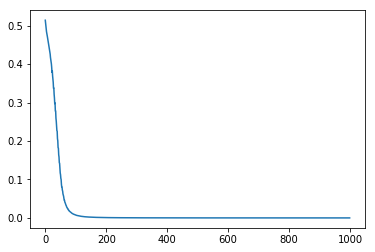

In [17]:
np.random.seed(1007)
EPOCH = 1000
N = X.shape[0]

mlp = MLP([2, 4, 2], learning_rate=.1, activation="relu")

loss = np.zeros(EPOCH)
for epoch in range(EPOCH):
    for i in range(N):
        mlp.train(X[i], Y[i])
        
    #print('Prediction: ', end="")
    for i in range(N):
        loss[epoch] += mlp.loss(X[i], Y[i])
        #print(mlp.predict(X[i]), end=" ")
        
    loss[epoch] /= N
    #print('Epoch %d, Loss: %f' % (epoch, loss[epoch]))
    
plt.figure()
ix = np.arange(EPOCH)
plt.plot(ix, loss)

## Tensorflow

### Keras

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(2, input_dim=2, activation=tf.nn.sigmoid))
model.add(Dense(2, activation=tf.nn.softmax))

sgd = SGD(lr=1)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, Y, epochs=2000)

NameError: name 'X' is not defined

### Raw

In [ ]:
import tensorflow as tf

In [ ]:
learning_rate = 1
training_epochs = 200

d_input = 2
d_hidden = 10
d_output = 2

In [ ]:
x = tf.placeholder("float", [None, d_input])
y = tf.placeholder("float", [None, d_output])

w1 = tf.Variable(tf.random_normal([d_input, d_hidden]))
b1 = tf.Variable(tf.random_normal([d_hidden]))
h1 = tf.nn.relu(tf.add(tf.matmul(x, w1), b1))

w2 = tf.Variable(tf.random_normal([d_hidden, d_output]))
b2 = tf.Variable(tf.random_normal([d_output]))
out = tf.add(tf.matmul(h1, w2), b2)

pred = tf.nn.softmax(out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):
        _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
        print("Epoch: %d, cost=%.9f" % (epoch+1, c))
        
    y_pred = sess.run([pred], feed_dict={x: X})
    print(y_pred)